# About the Data:

This API security captures API access patterns in terms of behavior metrics.

There are 2 datasets available. The one called supervised_dataset.csv has behaviors labeled as normal or outlier by human. The second file called remaining_behavior_ext.csv has a larger number of samples that are not labeled but has additional columns. It also has a classification created by another algorithm called ALGO-X. Each row is one instance of an observed behavior that has been manually classified as normal or outlier.

# Project Goal:

1.Use the supervised_dataset.csv to model the classification. Use cross validation to compare 2 different models, and choose the one that better fits the dataset.
/model 1
/model 2
/comparison, choose best

2.Use the remaining_behavior_ext to verify whether the predicted class differs from the class generated by the second algorithm. If so, improve the model/create new models that better fits the second algorithm.

/model 3
/comparison, draw conclusion

### Data

We'll be using a dataset from the Kaggle. Go to https://www.kaggle.com/datasets/tangodelta/api-access-behaviour-anomaly-dataset and download the zip file and unzip it.

We use **pandas** to read in data. Specifically, we use **read_csv** and specify the desired column names by passing in a list of *names*.

In [3839]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn import svm 
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras import callbacks
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

* Supervised_Dataset

In [3840]:
api = pd.read_csv('supervised_dataset.csv', delimiter=',', index_col=False).drop('Unnamed: 0', axis=1)
api.dataframeName = 'supervised_dataset.csv'
nRow, nCol = api.shape
print(f'There are {nRow} rows and {nCol} columns')
api.head()

There are 1699 rows and 11 columns


,_id,inter_api_access_duration(sec),api_access_uniqueness,sequence_length(count),vsession_duration(min),ip_type,num_sessions,num_users,num_unique_apis,source,classification
0,1f2c32d8-2d6e-3b68-bc46-789469f2b71e,0.000812,0.004066,85.643243,5405,default,1460.0,1295.0,451.0,E,normal
1,4c486414-d4f5-33f6-b485-24a8ed2925e8,0.000063,0.002211,16.166805,519,default,9299.0,8447.0,302.0,E,normal
2,7e5838fc-bce1-371f-a3ac-d8a0b2a05d9a,0.004481,0.015324,99.573276,6211,default,255.0,232.0,354.0,E,normal
3,82661ecd-d87f-3dff-855e-378f7cb6d912,0.017837,0.014974,69.792793,8292,default,195.0,111.0,116.0,E,normal
4,d62d56ea-775e-328c-8b08-db7ad7f834e5,0.000797,0.006056,14.952756,182,default,272.0,254.0,23.0,E,normal


Data Attributes


id: user id that requested the API call

inter_api_access_duration(sec): the duration time of the API access in sec

api_access_uniqueness: the uniquenesss of a request value

sequence_length(count): sequence length of the API request

vsession_duration(min): the duration time of the vsession in min

ip_type: the ip type

num_sessions: the number of sessions

num_users: the number of associated users

num_unique_apis: the number of unique APIs

source: the source

classification: human labeled classification results


* remaining_behavior_ext

In [3841]:
api_ext = pd.read_csv('remaining_behavior_ext.csv', delimiter=',', index_col=False).drop('Unnamed: 0', axis=1)
api_ext.dataframeName = 'remaining_behavior_ext.csv'
nRow, nCol = api_ext.shape
print(f'There are {nRow} rows and {nCol} columns')
api_ext.head()

There are 34423 rows and 12 columns


,_id,inter_api_access_duration(sec),api_access_uniqueness,sequence_length(count),vsession_duration(min),ip_type,behavior,behavior_type,num_sessions,num_users,num_unique_apis,source
0,024aae60-1a81-3f37-bbe6-3f832c919706,7.010387,0.419355,31.0,13040,default,outlier,outlier,1.0,1.0,13.0,E
1,028d67dd-c6d0-329f-a20e-78db9eab7a55,51.419393,0.252336,107.0,330113,default,outlier,outlier,1.0,1.0,27.0,E
2,02d12bf9-5fe2-3d0c-b233-30e02224b686,25.860775,0.275000,40.0,62066,default,outlier,outlier,1.0,1.0,11.0,E
3,0b3aee1e-dc3b-3728-bc55-f57a23446b3d,0.205909,0.818182,11.0,136,default,outlier,outlier,1.0,1.0,9.0,E
4,0dbfffb4-3ed4-3cb2-904d-c348501a996e,0.122125,0.812500,16.0,118,default,outlier,outlier,1.0,1.0,13.0,E


Data Attributes

id: user id that requested the API call

inter_api_access_duration(sec): the duration time of the API access in sec

api_access_uniqueness: the uniquenesss of a request value

sequence_length(count): sequence length of the API request

vsession_duration(min): the duration time of the vsession in min

ip_type: the ip type

behavior: the specific behavior of the API

behavior_type: classification results of the API

num_sessions: the number of sessions

num_users: the number of associated users

num_unique_apis: the number of unique APIs

source: the source


* Note that The different columns in the second dataset are the behavior and behavior_type(classification results given by ALGO_X algorithm)

# Data Analysis

* supervised_dataset

In [3842]:
api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1699 entries, 0 to 1698
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   _id                             1699 non-null   object 
 1   inter_api_access_duration(sec)  1695 non-null   float64
 2   api_access_uniqueness           1695 non-null   float64
 3   sequence_length(count)          1699 non-null   float64
 4   vsession_duration(min)          1699 non-null   int64  
 5   ip_type                         1699 non-null   object 
 6   num_sessions                    1699 non-null   float64
 7   num_users                       1699 non-null   float64
 8   num_unique_apis                 1699 non-null   float64
 9   source                          1699 non-null   object 
 10  classification                  1699 non-null   object 
dtypes: float64(6), int64(1), object(4)
memory usage: 146.1+ KB


There are 1699 non-null values in all the attributes. 

Datatype is either 'float64' or 'object'.

In [3843]:
api.groupby('classification').describe()

inter_api_access_duration(sec)                                 \
                                        count      mean        std       min   
classification                                                                 
normal                                 1106.0  0.006752   0.025078  0.000003   
outlier                                 589.0  4.307192  36.663570  0.000031   

                                                          \
                     25%       50%       75%         max   
classification                                             
normal          0.000239  0.000992  0.004513    0.272338   
outlier         0.007212  0.100778  0.923926  852.929250   

               api_access_uniqueness            ... num_users          \
                               count      mean  ...       75%     max   
classification                                  ...                     
normal                        1106.0  0.014329  ...     628.5  8447.0   
outlier                        589.0  0.471597  ...       1.0     1.0   

               num_unique_apis                                                \
                         count       mean        std  min   25%   50%    75%   
classification                                                                 
normal                  1106.0  94.440325  89.860256  2.0  31.0  68.0  125.5   
outlier                  593.0  16.527825  18.566070  0.0   4.0  11.0   22.0   

                       
                  max  
classification         
normal          524.0  
outlier         172.0  

[2 rows x 56 columns]

There are 1106 API calls that are marked as normal, and 589 API calls that are marked as outlier.

In [3844]:
api.describe()

,inter_api_access_duration(sec),api_access_uniqueness,sequence_length(count),vsession_duration(min),num_sessions,num_users,num_unique_apis
count,1695.000000,1695.000000,1699.000000,1.699000e+03,1699.000000,1699.000000,1699.000000
mean,1.501123,0.173226,61.648982,6.028341e+03,564.726898,406.263685,67.246616
std,21.697558,0.283641,205.803273,4.665042e+04,1179.931200,960.718580,82.189214
min,0.000003,0.001200,0.000000,1.000000e+00,2.000000,1.000000,0.000000
25%,0.000707,0.009199,9.984756,6.300000e+01,5.000000,1.000000,14.000000
50%,0.002574,0.018717,17.095238,1.950000e+02,164.000000,141.000000,37.000000
75%,0.024579,0.230769,41.349478,3.711500e+03,446.500000,308.500000,90.000000
max,852.929250,1.000000,3303.000000,1.352948e+06,9299.000000,8447.000000,524.000000


Note that num_sessions, num_users, num_unique_apis are significantly skewed
The other features almost shows the normal distribution, since their mean is equal to their respective medians.


<AxesSubplot:>

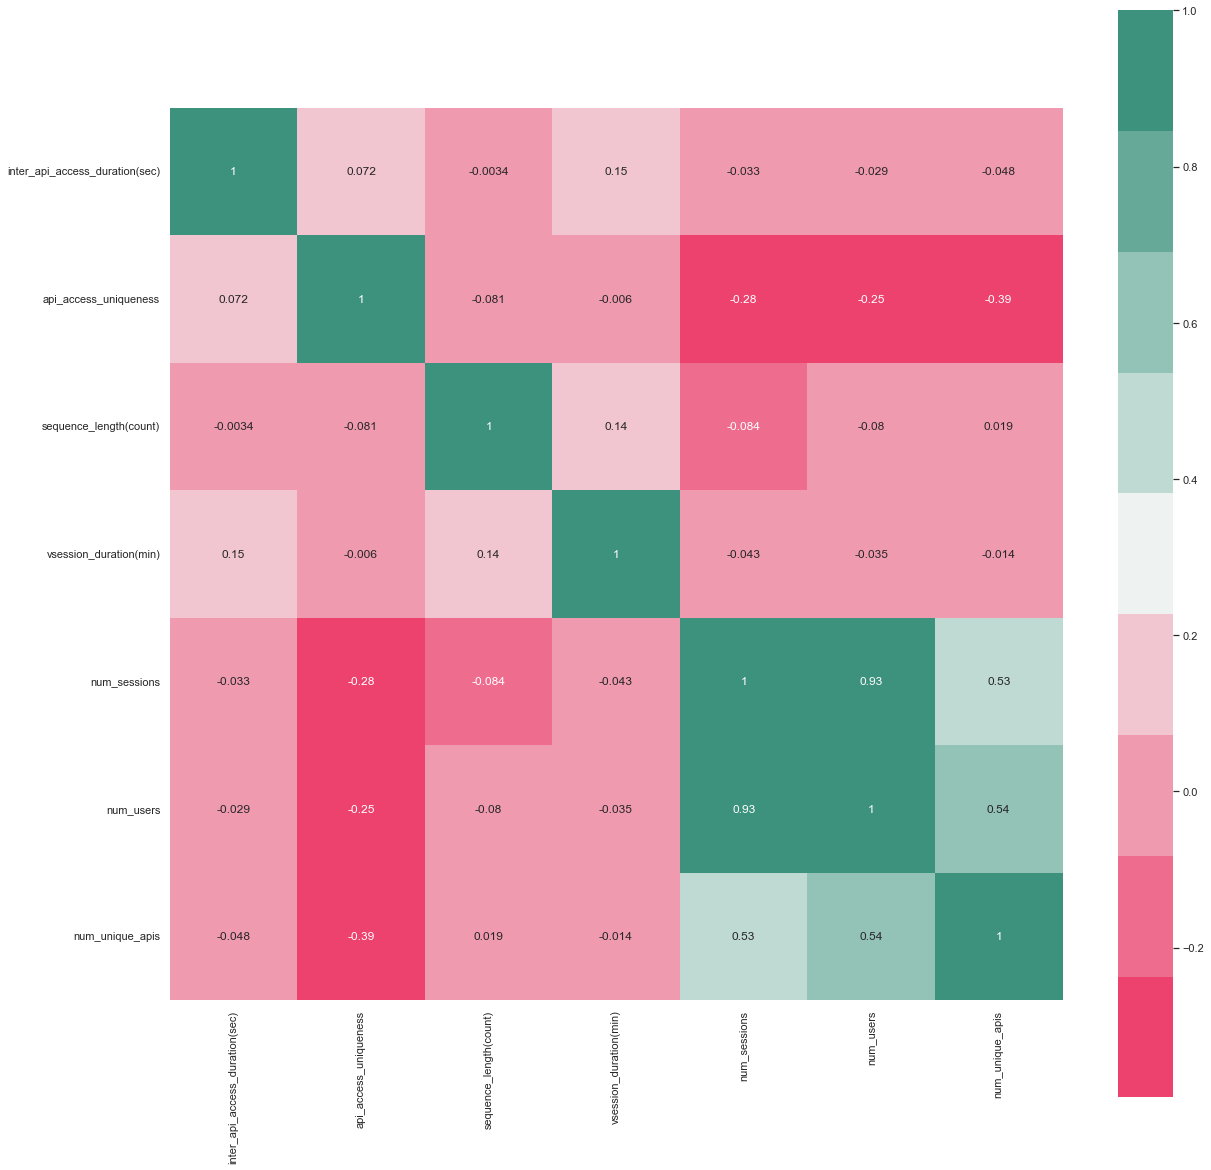

In [3845]:
#Doing Bivariate Analysis by examaning a corelation matrix of all the features using heatmap
cmap = sns.diverging_palette(2, 165, s=80, l=55, n=9)
corrmat = api.corr()
plt.subplots(figsize=(20,20))
sns.heatmap(corrmat,cmap= cmap,annot=True, square=True)

From the plot we can see that, api_access_uniqueness, num_sessions, num_users and num_unique_apis are strongly correlated. Other features has relatively low correlation between each other.

* remaining_behavior_ext

In [3846]:
api_ext.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34423 entries, 0 to 34422
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   _id                             34423 non-null  object 
 1   inter_api_access_duration(sec)  34422 non-null  float64
 2   api_access_uniqueness           34422 non-null  float64
 3   sequence_length(count)          34423 non-null  float64
 4   vsession_duration(min)          34423 non-null  int64  
 5   ip_type                         34423 non-null  object 
 6   behavior                        34423 non-null  object 
 7   behavior_type                   34423 non-null  object 
 8   num_sessions                    34423 non-null  float64
 9   num_users                       34423 non-null  float64
 10  num_unique_apis                 34423 non-null  float64
 11  source                          34423 non-null  object 
dtypes: float64(6), int64(1), object(

There are 34423 non-null values in all the attributes. 

Datatype is either 'float64' or 'object'.

In [3847]:
api_ext.groupby('behavior_type').describe()

inter_api_access_duration(sec)                                  \
                                       count       mean        std       min   
behavior_type                                                                  
attack                                  22.0  34.116884  32.233521  5.522434   
bot                                   1309.0  23.235137  98.726678  0.000000   
normal                                8946.0   8.477167  32.949457  0.000000   
outlier                              24145.0  24.863296  87.378357  0.000000   

                                                             \
                     25%        50%        75%          max   
behavior_type                                                 
attack         13.859714  18.676134  45.279946   112.015222   
bot             0.002065   0.011375   2.834125  1483.934200   
normal          0.179942   0.865120   3.782021   889.360833   
outlier         0.724921   3.278687  12.302500  2333.627333   

              api_access_uniqueness            ... num_users         \
                              count      mean  ...       75%    max   
behavior_type                                  ...                    
attack                         22.0  0.284409  ...       1.0    3.0   
bot                          1309.0  0.338693  ...       9.0  219.0   
normal                       8946.0  0.247167  ...       9.0  100.0   
outlier                     24145.0  0.523407  ...       1.0    1.0   

              num_unique_apis                                                 \
                        count       mean        std   min   25%   50%    75%   
behavior_type                                                                  
attack                   22.0  21.045455   2.663282  11.0  20.0  21.5  22.75   
bot                    1309.0   9.056532  10.885553   1.0   2.0   3.0  10.00   
normal                 8946.0  14.726917  13.016934   1.0   5.0  11.0  20.00   
outlier               24146.0  16.119067  16.251037   0.0   5.0  10.0  22.00   

                      
                 max  
behavior_type         
attack          24.0  
bot             50.0  
normal         178.0  
outlier        177.0  

[4 rows x 56 columns]

There are 8946 API calls that are marked as normal, and 24145 API calls that are marked as outlier. 22 marked as attack, and 1309 marked as bot.

To make the calssification of the 2 dataset consistent with each other, we will drop the dehavior type of 'attack' and 'bot'. Also that 'attack' and 'bot' data samples are small. Dropping them will not have significant result. 

And since we're dropping them, the 'behavior' and 'behavior_type' columns will be exactly the same(both normal, or both outlier) since 'behavior' is used to describe the detail of the 'behavior_type'. 

# Data Preprocessing

* supervised_dataset

1. Rename the columns for clean reading

In [3848]:
api.rename(columns = {'_id': 'id','inter_api_access_duration(sec)':'inter_api_access_duration', 'sequence_length(count)':'sequence_length','vsession_duration(min)':'vsession_duration'}, inplace=True)
api.head()


,id,inter_api_access_duration,api_access_uniqueness,sequence_length,vsession_duration,ip_type,num_sessions,num_users,num_unique_apis,source,classification
0,1f2c32d8-2d6e-3b68-bc46-789469f2b71e,0.000812,0.004066,85.643243,5405,default,1460.0,1295.0,451.0,E,normal
1,4c486414-d4f5-33f6-b485-24a8ed2925e8,0.000063,0.002211,16.166805,519,default,9299.0,8447.0,302.0,E,normal
2,7e5838fc-bce1-371f-a3ac-d8a0b2a05d9a,0.004481,0.015324,99.573276,6211,default,255.0,232.0,354.0,E,normal
3,82661ecd-d87f-3dff-855e-378f7cb6d912,0.017837,0.014974,69.792793,8292,default,195.0,111.0,116.0,E,normal
4,d62d56ea-775e-328c-8b08-db7ad7f834e5,0.000797,0.006056,14.952756,182,default,272.0,254.0,23.0,E,normal


In [3849]:
api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1699 entries, 0 to 1698
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         1699 non-null   object 
 1   inter_api_access_duration  1695 non-null   float64
 2   api_access_uniqueness      1695 non-null   float64
 3   sequence_length            1699 non-null   float64
 4   vsession_duration          1699 non-null   int64  
 5   ip_type                    1699 non-null   object 
 6   num_sessions               1699 non-null   float64
 7   num_users                  1699 non-null   float64
 8   num_unique_apis            1699 non-null   float64
 9   source                     1699 non-null   object 
 10  classification             1699 non-null   object 
dtypes: float64(6), int64(1), object(4)
memory usage: 146.1+ KB


2. _id is an object value. However, it's an unique id created by the company, and is not related to the classification result. So we decided to drop this feature.

In [3850]:
api=api.drop(columns='id')
api

,inter_api_access_duration,api_access_uniqueness,sequence_length,vsession_duration,ip_type,num_sessions,num_users,num_unique_apis,source,classification
0,0.000812,0.004066,85.643243,5405,default,1460.0,1295.0,451.0,E,normal
1,0.000063,0.002211,16.166805,519,default,9299.0,8447.0,302.0,E,normal
2,0.004481,0.015324,99.573276,6211,default,255.0,232.0,354.0,E,normal
3,0.017837,0.014974,69.792793,8292,default,195.0,111.0,116.0,E,normal
4,0.000797,0.006056,14.952756,182,default,272.0,254.0,23.0,E,normal
...,...,...,...,...,...,...,...,...,...,...
1694,45.603433,0.800000,15.000000,41044,datacenter,2.0,1.0,12.0,F,outlier
1695,852.929250,0.500000,2.000000,102352,datacenter,2.0,1.0,1.0,F,outlier
1696,59.243000,0.800000,5.000000,17773,datacenter,3.0,1.0,4.0,F,outlier
1697,0.754000,0.666667,3.000000,136,datacenter,2.0,1.0,2.0,F,outlier


3. inter_api_access_duration & api_access_uniqueness have 1695 non-null values(1699 entries in total), fill in the missing value with 0

In [3851]:
api.inter_api_access_duration = api.inter_api_access_duration.fillna('0')
api.api_access_uniqueness = api.api_access_uniqueness.fillna('0')
api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1699 entries, 0 to 1698
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   inter_api_access_duration  1699 non-null   object 
 1   api_access_uniqueness      1699 non-null   object 
 2   sequence_length            1699 non-null   float64
 3   vsession_duration          1699 non-null   int64  
 4   ip_type                    1699 non-null   object 
 5   num_sessions               1699 non-null   float64
 6   num_users                  1699 non-null   float64
 7   num_unique_apis            1699 non-null   float64
 8   source                     1699 non-null   object 
 9   classification             1699 non-null   object 
dtypes: float64(4), int64(1), object(5)
memory usage: 132.9+ KB


4. ip_type ,source are the categorized object value, implement Label encoding

In [3852]:
numeric_features = ['inter_api_access_duration','api_access_uniqueness','sequence_length','vsession_duration','num_sessions','num_users','num_unique_apis']
categorical_features = ['ip_type', 'source']

from sklearn.preprocessing import LabelEncoder, MinMaxScaler,StandardScaler
le = LabelEncoder()
api['ip_type']=le.fit_transform(api['ip_type'])
api['source']=le.fit_transform(api['source'])
api['classification']=le.fit_transform(api['classification'])

api.info()
api.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1699 entries, 0 to 1698
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   inter_api_access_duration  1699 non-null   object 
 1   api_access_uniqueness      1699 non-null   object 
 2   sequence_length            1699 non-null   float64
 3   vsession_duration          1699 non-null   int64  
 4   ip_type                    1699 non-null   int32  
 5   num_sessions               1699 non-null   float64
 6   num_users                  1699 non-null   float64
 7   num_unique_apis            1699 non-null   float64
 8   source                     1699 non-null   int32  
 9   classification             1699 non-null   int32  
dtypes: float64(4), int32(3), int64(1), object(2)
memory usage: 112.9+ KB


,inter_api_access_duration,api_access_uniqueness,sequence_length,vsession_duration,ip_type,num_sessions,num_users,num_unique_apis,source,classification
0,0.000812,0.004066,85.643243,5405,1,1460.0,1295.0,451.0,0,0
1,0.000063,0.002211,16.166805,519,1,9299.0,8447.0,302.0,0,0
2,0.004481,0.015324,99.573276,6211,1,255.0,232.0,354.0,0,0
3,0.017837,0.014974,69.792793,8292,1,195.0,111.0,116.0,0,0
4,0.000797,0.006056,14.952756,182,1,272.0,254.0,23.0,0,0


5. At last, standardalize the dataset using the StandardScaler

In [3853]:
api.describe()

,sequence_length,vsession_duration,ip_type,num_sessions,num_users,num_unique_apis,source,classification
count,1699.000000,1.699000e+03,1699.000000,1699.000000,1699.000000,1699.000000,1699.000000,1699.000000
mean,61.648982,6.028341e+03,0.907593,564.726898,406.263685,67.246616,0.117716,0.349029
std,205.803273,4.665042e+04,0.289685,1179.931200,960.718580,82.189214,0.322367,0.476803
min,0.000000,1.000000e+00,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000
25%,9.984756,6.300000e+01,1.000000,5.000000,1.000000,14.000000,0.000000,0.000000
50%,17.095238,1.950000e+02,1.000000,164.000000,141.000000,37.000000,0.000000,0.000000
75%,41.349478,3.711500e+03,1.000000,446.500000,308.500000,90.000000,0.000000,1.000000
max,3303.000000,1.352948e+06,1.000000,9299.000000,8447.000000,524.000000,1.000000,1.000000


The vsession_duration is significantly skewed. We'd better standardlize it. Also standarlize num_sessions and num_users. Other columns works fine.

In [3854]:
api[['vsession_duration','num_sessions','num_users']] = StandardScaler().fit_transform(api[['vsession_duration','num_sessions','num_users']])
api.info()
api.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1699 entries, 0 to 1698
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   inter_api_access_duration  1699 non-null   object 
 1   api_access_uniqueness      1699 non-null   object 
 2   sequence_length            1699 non-null   float64
 3   vsession_duration          1699 non-null   float64
 4   ip_type                    1699 non-null   int32  
 5   num_sessions               1699 non-null   float64
 6   num_users                  1699 non-null   float64
 7   num_unique_apis            1699 non-null   float64
 8   source                     1699 non-null   int32  
 9   classification             1699 non-null   int32  
dtypes: float64(5), int32(3), object(2)
memory usage: 112.9+ KB


,inter_api_access_duration,api_access_uniqueness,sequence_length,vsession_duration,ip_type,num_sessions,num_users,num_unique_apis,source,classification
0,0.000812,0.004066,85.643243,-0.013366,1,0.758974,0.925347,451.0,0,0
1,0.000063,0.002211,16.166805,-0.118133,1,7.404537,8.371966,302.0,0,0
2,0.004481,0.015324,99.573276,0.003917,1,-0.262573,-0.181442,354.0,0,0
3,0.017837,0.014974,69.792793,0.048538,1,-0.313438,-0.307427,116.0,0,0
4,0.000797,0.006056,14.952756,-0.125359,1,-0.248161,-0.158536,23.0,0,0


* remaining_behavior_ext

1. Rename the columns for clean reading. Rename the column 'behavior' to 'classification', to make the 2 dataset consistent with each other

In [3855]:
api_ext.rename(columns = {'_id': 'id','inter_api_access_duration(sec)':'inter_api_access_duration', 'sequence_length(count)':'sequence_length','vsession_duration(min)':'vsession_duration', 'behavior':'classification'}, inplace=True)
api_ext.head()

,id,inter_api_access_duration,api_access_uniqueness,sequence_length,vsession_duration,ip_type,classification,behavior_type,num_sessions,num_users,num_unique_apis,source
0,024aae60-1a81-3f37-bbe6-3f832c919706,7.010387,0.419355,31.0,13040,default,outlier,outlier,1.0,1.0,13.0,E
1,028d67dd-c6d0-329f-a20e-78db9eab7a55,51.419393,0.252336,107.0,330113,default,outlier,outlier,1.0,1.0,27.0,E
2,02d12bf9-5fe2-3d0c-b233-30e02224b686,25.860775,0.275000,40.0,62066,default,outlier,outlier,1.0,1.0,11.0,E
3,0b3aee1e-dc3b-3728-bc55-f57a23446b3d,0.205909,0.818182,11.0,136,default,outlier,outlier,1.0,1.0,9.0,E
4,0dbfffb4-3ed4-3cb2-904d-c348501a996e,0.122125,0.812500,16.0,118,default,outlier,outlier,1.0,1.0,13.0,E


2. Similarly as the supervised_dataset, we drop the id column. And as discussed in the Data analysis, drop the behavior_type column. At the same time, drop the data sample whose behavior types are 'attack' and 'bot'

In [3856]:
api_ext=api_ext.drop(api_ext[api_ext.behavior_type == 'attack'].index)
api_ext=api_ext.drop(api_ext[api_ext.behavior_type == 'bot'].index)
api_ext=api_ext.drop(columns=['id','behavior_type'])
api_ext
api_ext.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 33092 entries, 0 to 34422
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   inter_api_access_duration  33091 non-null  float64
 1   api_access_uniqueness      33091 non-null  float64
 2   sequence_length            33092 non-null  float64
 3   vsession_duration          33092 non-null  int64  
 4   ip_type                    33092 non-null  object 
 5   classification             33092 non-null  object 
 6   num_sessions               33092 non-null  float64
 7   num_users                  33092 non-null  float64
 8   num_unique_apis            33092 non-null  float64
 9   source                     33092 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 2.8+ MB


3. inter_api_access_duration & api_access_uniqueness have 44091 non-null values(33092 entries in total), fill in the missing value with 0

In [3857]:
api_ext.inter_api_access_duration = api_ext.inter_api_access_duration.fillna('0')
api_ext.api_access_uniqueness = api_ext.api_access_uniqueness.fillna('0')
api_ext.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33092 entries, 0 to 34422
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   inter_api_access_duration  33092 non-null  object 
 1   api_access_uniqueness      33092 non-null  object 
 2   sequence_length            33092 non-null  float64
 3   vsession_duration          33092 non-null  int64  
 4   ip_type                    33092 non-null  object 
 5   classification             33092 non-null  object 
 6   num_sessions               33092 non-null  float64
 7   num_users                  33092 non-null  float64
 8   num_unique_apis            33092 non-null  float64
 9   source                     33092 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 2.8+ MB


4. ip_type ,source are the categorized object value, implement Label encoding


In [3858]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler,StandardScaler
le = LabelEncoder()
api_ext['ip_type']=le.fit_transform(api_ext['ip_type'])
api_ext['source']=le.fit_transform(api_ext['source'])
api_ext['classification']=le.fit_transform(api_ext['classification'])

api_ext.info()
api_ext.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33092 entries, 0 to 34422
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   inter_api_access_duration  33092 non-null  object 
 1   api_access_uniqueness      33092 non-null  object 
 2   sequence_length            33092 non-null  float64
 3   vsession_duration          33092 non-null  int64  
 4   ip_type                    33092 non-null  int32  
 5   classification             33092 non-null  int32  
 6   num_sessions               33092 non-null  float64
 7   num_users                  33092 non-null  float64
 8   num_unique_apis            33092 non-null  float64
 9   source                     33092 non-null  int32  
dtypes: float64(4), int32(3), int64(1), object(2)
memory usage: 2.4+ MB


,inter_api_access_duration,api_access_uniqueness,sequence_length,vsession_duration,ip_type,classification,num_sessions,num_users,num_unique_apis,source
0,7.010387,0.419355,31.0,13040,1,1,1.0,1.0,13.0,0
1,51.419393,0.252336,107.0,330113,1,1,1.0,1.0,27.0,0
2,25.860775,0.275,40.0,62066,1,1,1.0,1.0,11.0,0
3,0.205909,0.818182,11.0,136,1,1,1.0,1.0,9.0,0
4,0.122125,0.8125,16.0,118,1,1,1.0,1.0,13.0,0


5. At last, standardalize the dataset using the StandardScaler

In [3859]:
api_ext.describe()

,sequence_length,vsession_duration,ip_type,classification,num_sessions,num_users,num_unique_apis,source
count,33092.000000,3.309200e+04,33092.000000,33092.000000,33092.000000,33092.000000,33092.000000,33092.000000
mean,66.653786,2.918656e+04,1.071528,0.729663,6.141394,3.266016,15.742717,0.498429
std,153.083031,7.819211e+04,0.386675,0.444141,35.346140,8.530978,15.455862,0.500005
min,0.000000,0.000000e+00,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,7.000000,6.950000e+02,1.000000,0.000000,1.000000,1.000000,5.000000,0.000000
50%,16.000000,6.337000e+03,1.000000,1.000000,1.000000,1.000000,10.000000,0.000000
75%,59.000000,2.528900e+04,1.000000,1.000000,3.000000,2.000000,21.000000,1.000000
max,2800.000000,2.787530e+06,3.000000,1.000000,1364.000000,100.000000,178.000000,1.000000


The vsession_duration is significantly skewed. We'd better standardlize it. Also standarlize sequence_length. Other columns works fine.

In [3860]:
api_ext[['sequence_length','vsession_duration']] = StandardScaler().fit_transform(api_ext[['sequence_length','vsession_duration']])
api_ext.info()
api_ext.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33092 entries, 0 to 34422
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   inter_api_access_duration  33092 non-null  object 
 1   api_access_uniqueness      33092 non-null  object 
 2   sequence_length            33092 non-null  float64
 3   vsession_duration          33092 non-null  float64
 4   ip_type                    33092 non-null  int32  
 5   classification             33092 non-null  int32  
 6   num_sessions               33092 non-null  float64
 7   num_users                  33092 non-null  float64
 8   num_unique_apis            33092 non-null  float64
 9   source                     33092 non-null  int32  
dtypes: float64(5), int32(3), object(2)
memory usage: 2.4+ MB


,inter_api_access_duration,api_access_uniqueness,sequence_length,vsession_duration,ip_type,classification,num_sessions,num_users,num_unique_apis,source
0,7.010387,0.419355,-0.232908,-0.206502,1,1,1.0,1.0,13.0,0
1,51.419393,0.252336,0.263562,3.848611,1,1,1.0,1.0,27.0,0
2,25.860775,0.275,-0.174116,0.420502,1,1,1.0,1.0,11.0,0
3,0.205909,0.818182,-0.363558,-0.371534,1,1,1.0,1.0,9.0,0
4,0.122125,0.8125,-0.330896,-0.371764,1,1,1.0,1.0,13.0,0


# Apply different models using supervised_dataset

We discovered that both datasets have overfitting problems based on the property of limited features and imbalanced dataset. Therefore, we would apply regression model first to maximize the probability and then apply the classification models.

* First model: Bayesian Ridge Regression

    We would apply Bayesian Ridge Regression on supervised_dataset to check its performance first

1. Import all necessary packages here and prepare the data segments. In this case, we will continue to apply StratifiedKfold among all supervised_dataset models.

In [3861]:
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_squared_log_error

import matplotlib.pyplot as plt
from numpy import sqrt
X, y = api.drop(['classification'], axis=1), api.classification


2. We first could try to use default parameters and fit in with train data and print out the model score (R-squared)

In [3862]:
kf = StratifiedKFold(n_splits=4) #4 folds
kf.get_n_splits(X)

for train, test in kf.split(X, y):
    X_train1, X_test1 = X.iloc[train], X.iloc[test]
    y_train1, y_test1 = y.iloc[train], y.iloc[test]
    bay_ridge = BayesianRidge().fit(X_train1, y_train1)
    score=bay_ridge.score(X_train1, y_train1)
    #print(y_test1)
    print("Model score (R-squared) for supervised_dataset: %.2f" % score)

Model score (R-squared) for supervised_dataset: 0.78
Model score (R-squared) for supervised_dataset: 0.76
Model score (R-squared) for supervised_dataset: 0.78
Model score (R-squared) for supervised_dataset: 0.77


3. Then, we calculate the mean squared log error and root mean squared error, and visualize the prediction and original data for supervised_dataset.
* Note: since there are some negative data points in predicted values, we need to apply absolute values on it but it would not influence SVC later, neither or barely influence the MSLE metrics.

There are 4 negative values in the predicted values.
Mean_squared_log_error: 0.05
Root_mean_squared_error: 0.22


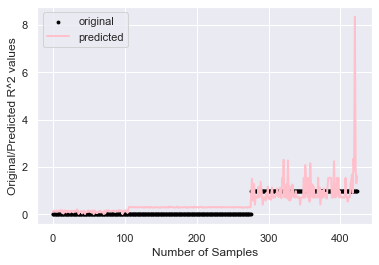

In [3863]:
y_pred = bay_ridge.predict(X_test1)
# Count the negative values predicted:
count_neg=0
for i in y_pred:
    if i < 0:
        count_neg+=1
print("There are", count_neg, "negative values in the predicted values.")
msle = mean_squared_log_error(y_test1, abs(y_pred))
print("Mean_squared_log_error: %.2f" % msle)
print("Root_mean_squared_error: %.2f" % sqrt(msle))
x_ax = range(len(y_test1))
plt.scatter(x_ax, y_test1, s=8, color="black", label="original")
plt.plot(x_ax, abs(y_pred), lw=2, color="pink", label="predicted")
plt.xlabel("Number of Samples")
plt.ylabel("Original/Predicted R^2 values")
plt.legend()
plt.show() 

Now, we apply SVM classification model then depict the evaluation metrics.

Accuracy: 0.7169811320754716
F1 score: 0.7115384615384616
AUPRC: 0.9690973061346179


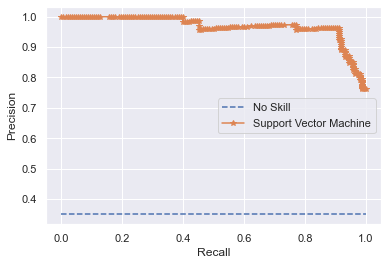

In [3864]:
clf = svm.SVC(probability=True)
clf.fit(X_train1, y_train1)
y_pred = clf.predict_proba(X_test1)
y_hat1 = clf.predict(X_test1)
print("Accuracy:", accuracy_score(y_test1, y_hat1))
print("F1 score:", f1_score(y_test1, y_hat1))
fraud_precision, fraud_recall, thresholds = precision_recall_curve(y_test1, y_pred[:, 1])
print("AUPRC:", auc(fraud_recall, fraud_precision))
no_skill = len(y_test1[y_test1==1]) / len(y_test1)
plt.plot([0, 1], [no_skill, no_skill], linestyle="--", label='No Skill')
plt.plot(fraud_recall, fraud_precision, marker='*', label='Support Vector Machine')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

We obtain the combinations of BayesianRidge Regression and SVM has accuracy 0.717, F1 score 0.712, and AUPRC 0.969.

* Second model: Logistic Regression with Support Vector Machine

    We would apply Support Vector Machine on supervised_dataset to give us more consolidate results and compare to the previous combination

* Before doing so, we could try the approach of Recursive feature elimination with cross-validation to choose how many features are optimal

    Reference: https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py

Optimal number of features : 9


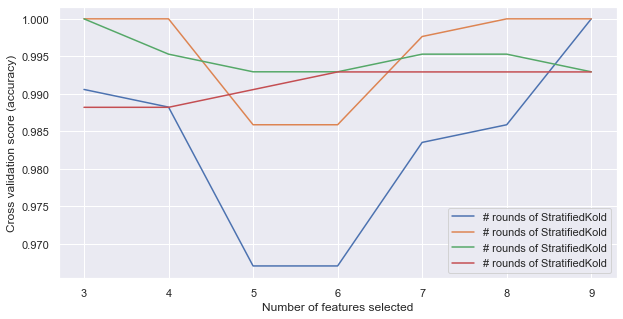

In [3865]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV


# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy"s scoring shows the proportion of correct classifications

min_features_to_select = 3  # Minimum number of features to consider
rfecv = RFECV(
    estimator=svc,
    step=1,
    cv=StratifiedKFold(4),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure(figsize=[10, 5])
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
    label="# rounds of StratifiedKold",
)
plt.legend()
plt.show()

* Now we could apply SVM with all 9 features
1. Import the associated packages and split the data (using the previous method and set the test size = 0.4)

In [3866]:
from sklearn.metrics import auc, precision_recall_curve
from sklearn import svm

2. Apply the Logistic Regression model with solvers = sag && saga. We tried all the solvers for "sag", "liblinear", "lbfgs", "newton-cg" as shown below and based on their accuracy score, we chose that the best Logistic Regression model with SVM is "sag" and we would apply SVC on trained dataset with sag. 

F1 score with sag: 0.8538461538461538
AUPRC with sag: 0.9964417767824376
F1 score with saga: 0.8796992481203008
AUPRC with saga: 0.9963645543551947
F1 score with sag: 0.8016194331983807
AUPRC with sag: 0.9989075108189788
F1 score with saga: 0.8437499999999999
AUPRC with saga: 0.9986995922577153
F1 score with sag: 0.8174603174603174
AUPRC with sag: 0.9988207366659997
F1 score with saga: 0.8494208494208495
AUPRC with saga: 0.9988665445096798
F1 score with sag: 0.875
AUPRC with sag: 0.9600797326019774
F1 score with saga: 0.8837209302325582
AUPRC with saga: 0.9507912849721083
Token Counts f1 score saga:  0.836981476126213
Token Counts f1 score sag:  0.864147756943427


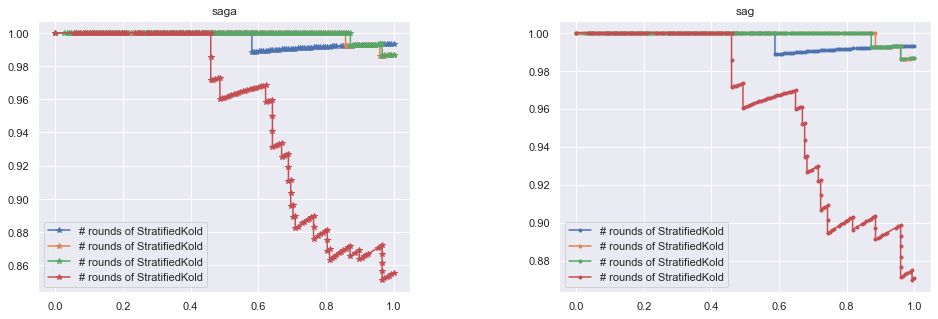

In [3867]:
# Let's try 4 fold cross validation with logistic regression
# And with two different solvers to see if there would be any difference
from sklearn.linear_model import LogisticRegression
kf = StratifiedKFold(n_splits=4) #4 folds
#feature_cols = ['inter_api_access_duration','api_access_uniqueness', 'sequence_length',	'vsession_duration','ip_type']
#X = api[feature_cols] 
X = api.drop('classification', axis=1)
y = api['classification']
kf.get_n_splits(X)
fig_size = [16, 5]

fig = plt.figure(figsize=fig_size)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax_sag = fig.add_subplot(1, 2, 1)
ax_saga = fig.add_subplot(1, 2, 2)
f1_sag = []
f1_saga = []
solvers = ["sag","lbfgs","liblinear","newton-cg"]

for train, test in kf.split(X, y):
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]

    clf1 = LogisticRegression(solver="saga").fit(X_train, y_train)
    y_pred1 = clf1.predict_proba(X_test)
    y_hat1 = clf1.predict(X_test)
    clf2 = LogisticRegression(solver=solvers[0]).fit(X_train, y_train)
    y_pred2 = clf2.predict_proba(X_test)
    y_hat2 = clf2.predict(X_test)
  
    print("F1 score with sag:", f1_score(y_test, y_hat1))
    f1_saga.append(f1_score(y_test, y_hat1))
    fraud_precision, fraud_recall, thresholds = precision_recall_curve(y_test, y_pred1[:, 1])
    print("AUPRC with sag:", auc(fraud_recall, fraud_precision))
    ax_saga.plot(fraud_recall, fraud_precision, marker='.', label="# rounds of StratifiedKold")
    ax_saga.set_title('sag')
    ax_saga.legend()
    
    print("F1 score with saga:", f1_score(y_test, y_hat2))
    f1_sag.append(f1_score(y_test, y_hat2))
    fraud_precision, fraud_recall, thresholds = precision_recall_curve(y_test, y_pred2[:, 1])
    print("AUPRC with saga:", auc(fraud_recall, fraud_precision))
    ax_sag.plot(fraud_recall, fraud_precision, marker='*', label="# rounds of StratifiedKold")
    ax_sag.set_title('saga')
    ax_sag.legend()
mean_f1_saga = sum(f1_saga)/len(f1_saga)
mean_f1_sag = sum(f1_sag)/len(f1_sag)
print('Token Counts f1 score saga: ', str(mean_f1_saga)) 
print('Token Counts f1 score sag: ', str(mean_f1_sag))

2. Apply the above SVC model with Logistic Regression algorithm "sag" based on their accuracy score, and print out its desired evaluation metrics

Accuracy: 0.9174528301886793
F1 score: 0.8837209302325582
AUPRC: 0.9507912849721083


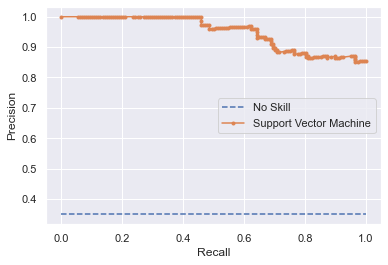

In [3868]:
clf = svm.SVC(probability=True)
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)
y_hat = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_hat2))
print("F1 score:", f1_score(y_test, y_hat2))
fraud_precision, fraud_recall, thresholds = precision_recall_curve(y_test, y_pred2[:, 1])
print("AUPRC:", auc(fraud_recall, fraud_precision))
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle="--", label='No Skill')
plt.plot(fraud_recall, fraud_precision, marker='.', label='Support Vector Machine')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

To summarize, our Logistic Regression model with SVC outputs the accuracy score around 0.92, F1 score 0.88, and AUPRC 0.95 using supervised_dataset.

# Apply different models on extension dataset (unlabeled dataset)

* First model for unlabled dataset we chose: GMM.
* We split the dataset using the same method as we did in our previous GMM homework and apply our GMM model on it. (3-way cross validation with data split=[Training=80% normal, Validation=10% normal+50% abnormal, Test=10% normal + 50% abnormal])

In [3869]:
from sklearn.mixture import GaussianMixture
normal = api_ext[api_ext['classification'] == 0]
anomaly = api_ext[api_ext['classification'] == 1]
print(normal.shape)
print(anomaly.shape)
# train data is only from normal dataset, and take 80% of normal data
train, normal_test, _, _ = train_test_split(normal, normal, test_size=.2, random_state=6)
# split the original dataset into 50% validation data and 50% test data.
normal_valid, normal_test, _, _ = train_test_split(normal_test, normal_test, test_size=.5, random_state=6)
anormal_valid, anormal_test, _, _ = train_test_split(anomaly, anomaly, test_size=.5, random_state=6)

train = train.reset_index(drop=True)
valid = normal_valid.append(anormal_valid).reset_index(drop=True)
test = normal_test.append(anormal_test).reset_index(drop=True)

print('Train shape: ', train.shape)
print('Proportion os anomaly in training set: %.3f\n' % train['classification'].mean())
print('Valid shape: ', valid.shape)
print('Proportion os anomaly in validation set: %.3f\n' % valid['classification'].mean())
print('Test shape: ', test.shape)
print('Proportion os anomaly in test set: %.3f\n' % test['classification'].mean())

train_df = train.copy()
valid_df = valid.copy()
test_df = test.copy()
#print(train_df, valid_df, test_df)
#only use ['V17', 'V14', 'V12', 'V10']
train_df.drop('classification', axis =1, inplace = True)
#train_df.drop('classification', axis=1, inplace=True)
#max_diff = 0
gmm = GaussianMixture(n_components=3, n_init=4, random_state=6)
gmm.fit(train_df)
print(gmm.score(train_df))
#a = gmm.score(valid_df[valid_df['classification'] == 0].drop('classification', axis=1).values)
print(gmm.score(valid_df[valid_df['classification'] == 0].drop('classification', axis=1).values))
#b = gmm.score(valid_df[valid_df['classification'] == 1].drop('classification', axis=1).values)
print(gmm.score(valid_df[valid_df['classification'] == 1].drop('classification', axis=1).values))


(8946, 10)
(24146, 10)
Train shape:  (7156, 10)
Proportion os anomaly in training set: 0.000

Valid shape:  (12968, 10)
Proportion os anomaly in validation set: 0.931

Test shape:  (12968, 10)
Proportion os anomaly in test set: 0.931

1.5772187723174607
1.7703301467839438
-113319.51324670775


* Select the threshold based on the previous validation dataset score.

In [3870]:
tresholds = np.linspace(-150, 25, 200)
y_scores = gmm.score_samples(valid_df.drop('classification', axis=1).values)
scores = []
y_true=valid_df['classification'].values
for treshold in tresholds:
    y_hat = (y_scores < treshold).astype(int)
    scores.append([recall_score(y_true, y_hat),
                 precision_score(y_true, y_hat),
                 f1_score(y_true, y_hat)])

scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())

0.9741266731962128 174


* Print out the evaluation metrics based on different thresholds.

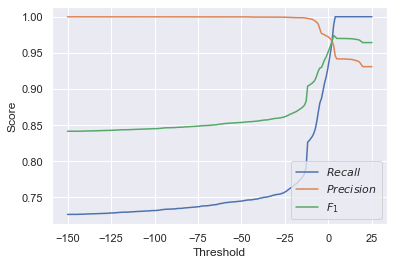

In [3871]:
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_1$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

* Select the optimal threshold and evaluate the test dataset.

In [3872]:
# So, the final threshold that the valid set helped to determine is
final_tresh = tresholds[scores[:, 2].argmax()]
print ('The final threshold selected is: ', final_tresh)
#Now let's see how well this threshold works with test data
test_df = test.copy()
#test_df.drop(['source', 'sequence_length'], axis =1, inplace = True)
y_hat_test = (gmm.score_samples(test_df.drop('classification', axis=1).values) < final_tresh).astype(int)
y_true=test_df['classification'].values

print('Final threshold: %f' % final_tresh)
print('Accuracy score:  %.3f' % accuracy_score(y_true, y_hat_test))
print('Test Recall Score: %.3f' % recall_score(y_true, y_hat_test))
print('Test Precision Score: %.3f' % precision_score(y_true, y_hat_test))
print('Test F1 Score: %.3f' % f1_score(y_true, y_hat_test))

cnf_matrix = confusion_matrix(test_df['classification'].values, y_hat_test)
print("tn, fp, fn, tp:",  cnf_matrix.ravel())

The final threshold selected is:  3.0150753768844254
Final threshold: 3.015075
Accuracy score:  0.954
Test Recall Score: 0.990
Test Precision Score: 0.961
Test F1 Score: 0.975
tn, fp, fn, tp: [  414   481   120 11953]


The final scores for GMM model we obtained are: F1: 0.975, Precision: 0.961, Recall: 0.990, and Accuracy score: 0.954.

Our second model Autoencoder for unlabeled data would be in Autoencoder.ipynb.